# Evaluación de sistemas de preguntas y respuestas con datos dinámicos
En muchos escenarios del mundo real, la respuesta correcta a una pregunta puede cambiar con el tiempo. Por ejemplo, si está creando un sistema de preguntas y respuestas sobre una base de datos o que se conecta a una API, los datos subyacentes pueden actualizarse con frecuencia. En tales casos, aún querrá medir la corrección de su sistema, pero querrá hacerlo de una manera que tenga en cuenta estos cambios.

En el siguiente tutorial, utilizaremos la antigua práctica del software de direccionamiento indirecto para solucionar este problema. En lugar de almacenar etiquetas directamente como valores, nuestras etiquetas serán referencias para buscar los valores correctos. En este caso, nuestras etiquetas serán consultas que el evaluador personalizado puede usar para obtener la respuesta de verdad fundamental y compararla con las predicciones del modelo.

El tutorial lo guiará a través de los siguientes pasos:

Cree un conjunto de datos de preguntas y fragmentos de código correspondientes para obtener las respuestas.
Defina su sistema de preguntas y respuestas.
Ejecute la evaluación utilizando LangSmith con un evaluador personalizado.
Vuelva a probar el sistema con el tiempo.
Nota rápida: estamos utilizando un archivo CSV para simular una fuente de datos real. Este no es un escenario real y pretende ser ilustrativo.

¡Vamos a empezar!

## Prerequisitos

Este tutorial usa OpenAI para el modelo y LangChain para componer la cadena. Para asegurarse de que el seguimiento y las evaluaciones estén configurados para LangSmith, configure su clave API de manera adecuada.

In [2]:
import os
import openai
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv() # read local .env file
openai.api_key = os.environ['OPENAI_API_KEY']

In [3]:
from langchain.chat_models import ChatOpenAI

llm = ChatOpenAI()
llm.predict("Hello, world!")

'Hello! How can I assist you today?'

### 1. Create a dataset

Usaremos el conjunto de datos Titanic de <https://raw.githubusercontent.com/jorisvandenbossche/pandas-tutorial/master/data/titanic.csv> para nuestro ejemplo. Este conjunto de datos contiene información sobre los pasajeros del Titanic, junto con sus resultados.

Primero, defina un conjunto de preguntas y referencias correspondientes que muestren cómo recuperar la respuesta correcta de los datos. Por el bien del tutorial, usaremos fragmentos de código de Python, pero la táctica se puede aplicar generalmente a cualquier otra forma de direccionamiento indirecto, como almacenar solicitudes de API o argumentos de búsqueda.

Nuestro evaluador utilizará las referencias para obtener la respuesta correcta.

In [4]:
questions = [
    ("How many passengers were on the Titanic?", "len(df)"),
    ("How many passengers survived?", "df['Survived'].sum()"),
    ("What was the average age of the passengers?", "df['Age'].mean()"),
    ("How many male and female passengers were there?", "df['Sex'].value_counts()"),
    ("What was the average fare paid for the tickets?", "df['Fare'].mean()"),
    ("How many passengers were in each class?", "df['Pclass'].value_counts()"),
    ("What was the survival rate for each gender?", "df.groupby('Sex')['Survived'].mean()"),
    ("What was the survival rate for each class?", "df.groupby('Pclass')['Survived'].mean()"),
    ("Which port had the most passengers embark from?", "df['Embarked'].value_counts().idxmax()"),
    ("How many children under the age of 18 survived?", "df[df['Age'] < 18]['Survived'].sum()")
]


​A continuación, ¡cree el conjunto de datos! Puede utilizar el SDK de LangSmith para hacerlo. Cree el conjunto de datos y cargue cada ejemplo. Guardar el conjunto de datos en LangSmith nos permite reutilizar y relacionar las ejecuciones de prueba a lo largo del tiempo.

In [5]:
from langsmith import Client

client = Client()
dataset_name = "Dynamic Titanic CSV31352"
dataset = client.create_dataset(
    dataset_name=dataset_name, description="Test QA over CSV",
)

for example in questions:
    client.create_example(
        inputs={"question": example[0]},
        outputs={"code": example[1]},
        dataset_id=dataset.id,
    )

### 2. Definir el sistema de preguntas y respuestas
Con el conjunto de datos creado, es hora de definir nuestro sistema de respuesta a preguntas. Usaremos el agente de marco de datos pandas comercial de LangChain para este tutorial.

Primero, cargue los datos dinámicos en un marco de datos, luego cree un constructor para nuestro agente.

In [6]:
import pandas as pd

titanic_path = "https://raw.githubusercontent.com/jorisvandenbossche/pandas-tutorial/master/data/titanic.csv"
df = pd.read_csv(titanic_path)

In [7]:
from functools import partial

from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.agents import create_pandas_dataframe_agent

llm = ChatOpenAI(model="gpt-4", temperature=0.0)
create_chain = partial(
    create_pandas_dataframe_agent,
    llm=llm,
    df=df,
)

In [33]:
# Example run
create_chain().invoke({"input": "How many passengers were on the Titanic?"})

{'input': 'How many passengers were on the Titanic?',
 'output': 'There were 891 passengers on the Titanic.'}

### 3. Ejecutar evaluación
Ahora es el momento de definir nuestro evaluador personalizado. En este caso heredaremos de la clase LabeledCriteriaEvalChain. Este evaluador toma la entrada, la predicción y la etiqueta de referencia y los pasa a un LLM para predecir si la predicción satisface los criterios proporcionados, condicionados a la etiqueta de referencia.

Nuestro evaluador personalizado hará un pequeño cambio en este evaluador eliminando la referencia de la etiqueta para inyectar el valor correcto. Hacemos esto sobrescribiendo el método _get_eval_input. Luego, el LLM verá el nuevo valor de referencia.

Recordatorio: estamos usando un archivo CSV para simular una fuente de datos real aquí y estamos haciendo una evaluación insegura para consultar la fuente de datos. En un escenario real, sería mejor hacer una solicitud de obtención segura o algo similar.

In [34]:
from langsmith import Client
from langchain.smith import RunEvalConfig, run_on_dataset
from typing import Optional
from langchain.evaluation.criteria.eval_chain import LabeledCriteriaEvalChain

class CustomCriteriaEvalChain(LabeledCriteriaEvalChain):
    def _get_eval_input(
        self,
        prediction: str,
        reference: Optional[str],
        input: Optional[str],
    ) -> dict:
        # The parent class validates the reference is present and combines into
        # a dictionary for the llm chain.
        raw = super()._get_eval_input(prediction, reference, input)
        # Warning - this evaluates the code you've saved as labels in the dataset.
        # Be sure that the code is correct, and refrain from executing in an
        # untrusted environment or when connected to a production server.
        raw["reference"] = eval(raw["reference"])
        return raw

In [35]:
client = Client()
eval_config = RunEvalConfig(
    custom_evaluators=[
        CustomCriteriaEvalChain.from_llm(criteria="correctness", llm=ChatOpenAI(model="gpt-4", temperature=0.0)),
    ],
)
chain_results = run_on_dataset(
    client,
    dataset_name=dataset_name,
    llm_or_chain_factory=create_chain,
    evaluation=eval_config,
    # This agent doesn't support concurrent runs yet.
    concurrency_level=1
)

View the evaluation results for project 'e86f34530bc94e3b88d4e312c98cc01f-AgentExecutor' at:
https://smith.langchain.com/projects/p/3a68edb6-7748-4612-b2e5-d81d7db92d0b?eval=true


Con esa evaluación en ejecución, puede navegar hasta el proyecto vinculado y revisar las predicciones y los puntajes de retroalimentación del agente.

### 4. Vuelva a evaluar más tarde.
Es seguro decir que el conjunto de datos del Titanic no ha cambiado en los últimos minutos, pero en su caso, es probable que ingresen nuevos datos todo el tiempo. Mientras la forma de acceder a esa información no haya cambiado, ¡podemos reutilizar el conjunto de datos existente!

Supongamos que más personas abordaron duplicando algunas filas y barajando algunas estadísticas. Luego, volveremos a ejecutar el agente en el nuevo conjunto de datos.


In [36]:
df_doubled = pd.concat([df, df], ignore_index=True)
df_doubled['Age'] = df_doubled['Age'].sample(frac=1).reset_index(drop=True)
df_doubled['Sex'] = df_doubled['Sex'].sample(frac=1).reset_index(drop=True)
df = df_doubled

In [37]:
create_chain_2 = partial(
    create_pandas_dataframe_agent,
    llm=llm,
    df=df,
)

In [38]:
chain_results = run_on_dataset(
    client,
    dataset_name=dataset_name,
    llm_or_chain_factory=create_chain_2,
    evaluation=eval_config,
    concurrency_level=1
)

View the evaluation results for project '31fc6dfb40534f038071091e09db44c7-AgentExecutor' at:
https://smith.langchain.com/projects/p/58aece77-8ed2-4ef9-96ec-d3015af0cd45?eval=true


#### Revisa los resultados
Ahora que ha probado dos veces en la fuente de datos "cambiante", ¡puede ver los resultados! Si navega a la página "conjunto de datos" y hace clic en la pestaña "ejemplos", puede hacer clic en diferentes ejemplos y ver las predicciones para cada ejecución de prueba.

A continuación se muestra la vista de las filas de conjuntos de datos individuales. Podemos hacer clic en una fila para actualizar el ejemplo o para ver todas las predicciones de diferentes ejecuciones de prueba en ese ejemplo. ¡Hagamos clic en uno!

En este caso, hemos seleccionado la fila de ejemplo con la pregunta "¿Cuántos pasajeros hombres y mujeres había?" La tabla de filas vinculadas en la parte inferior de la página muestra las predicciones para cada ejecución de prueba. Estos se asocian automáticamente cada vez que llama a run_on_dataset.

¡Si miras de cerca las predicciones, verás que las predicciones son diferentes! En un principio, el agente pronosticó 577 pasajeros masculinos y 314 femeninos. Luego, para la segunda prueba, predijo 1154 pasajeros masculinos y 628 femeninos.

Sin embargo, ambas ejecuciones de prueba se marcaron como "correctas". Los valores dentro de la fuente de datos cambiaron, pero el proceso para recuperar la respuesta siguió siendo el mismo.

Pero, ¿cómo puede estar seguro de que la calificación "correcta" es confiable? Ahora es un buen momento para verificar el seguimiento de ejecución de su evaluador personalizado para confirmar que funciona como se esperaba. Si ve flechas en las fichas de "corrección" en la tabla, puede hacer clic directamente en ellas para ver el seguimiento de la evaluación. De lo contrario, puede hacer clic en la ejecución, navegar a la pestaña de comentarios y luego hacer clic para encontrar el seguimiento de su evaluador personalizado para ese ejemplo. A continuación se muestran capturas de pantalla de los valores recuperados para cada una de las ejecuciones anteriores.

Puede ver que la clave de "referencia" contiene el valor desreferenciado de la fuente de datos. ¡Puedes ver que coincide con las predicciones de las carreras anteriores! El primero muestra 577 pasajeros masculinos y 314 femeninos.

Y después de que se actualizó el marco de datos, el evaluador recuperó el valor correcto de 1154 pasajeros masculinos y 628 femeninos, ¡lo que coincide con las predicciones de las carreras anteriores!

Página de ejemplos
¡Parece estar funcionando bien!

#### Conclusiones

En este tutorial, evaluó un sistema de preguntas y respuestas conectado a un almacén de datos en evolución. Lo hizo usando un evaluador personalizado que obtiene dinámicamente la respuesta en función de una referencia estática (en este caso, un fragmento de código).

¡Esta es solo una forma de abordar el problema de evaluar los sistemas de preguntas y respuestas cuando la fuente de datos subyacente está cambiando! Este enfoque es simple y prueba directamente la corrección de su sistema de principio a fin con datos actualizados. Puede ser útil si desea controlar su desempeño periódicamente.

Es menos confiable si su objetivo es comparar dos indicaciones o modelos diferentes, ya que los datos subyacentes pueden diferir. Dependiendo de cómo elimine las referencias de las etiquetas, ¡la precaución y los permisos adecuados también son importantes!

Otras opciones para evaluar su sistema en este escenario incluyen:

Congelar o burlarse de las fuentes de datos utilizadas para la evaluación. Luego puede invertir en el etiquetado manual periódicamente para asegurarse de que los datos sigan siendo representativos del entorno de producción.
Probar la capacidad de generación de consultas de su agente directamente y evaluar la equivalencia de las consultas. Esto es menos "extremo a extremo", pero dependiendo de cómo se compare, evitará cualquier problema potencial causado por la desreferenciación insegura.



# Revisar el estado del arte de las metricas de las aplicaciones de LLM

En la última década, los avances en el campo de la Inteligencia Artificial (IA) han llevado a la creación de modelos de lenguaje cada vez más grandes y sofisticados. Estos modelos, conocidos como Modelos de Lenguaje Largo (LLM), han demostrado su eficacia en una amplia gama de aplicaciones, como generación de texto, traducción automática, resumen de texto y respuesta a preguntas. La evaluación precisa y objetiva de estos modelos es esencial para medir su rendimiento y garantizar resultados de alta calidad en diversas tareas.


## Perplejidad
Es una métrica de evaluación de modelado lingüístico intrínseca que mide la inversa de la probabilidad de media geométrica por palabra en los datos de prueba. Una puntuación de perplejidad más baja indica un mejor rendimiento de generalización. Las investigaciones han demostrado que la probabilidad calculada por palabra a menudo no se alinea con el juicio humano y puede no estar totalmente correlacionada, por lo que se ha introducido la coherencia temática. 

Se puede encontrar que una frase $x_i$ en el conjunto de prueba puede ser codificada de media mediante $190$ bits (p.e, si las frases de prueba tienen una media de probabilidad logarítmica de $-190$). Este valor nos daría un valor enorme de perplejidad de $2190$ por frase. Sin embargo, es más común normalizar por la longitud de la frase y considerar sólo el número de bits por palabra. De esta manera, si las frases de un conjunto de entrenamiento constan de un total de $1000$ palabras, y éstas se codifican mediante $7950$ bits, se da la perplejidad del modelo como $2^{7.95} = 247$ por palabra. En otras palabras, el modelo se confunde en el conjunto de prueba como si tuviese que elegir uniforme e independientemente entre 247 posibilidades por cada palabra.

## BLEU (Bilingual Evaluation Understudy)
Es un método de evaluación de la calidad de traducciones realizadas por sistemas de traducción automática. Una traducción tiene mayor calidad cuanto más similar es con respecto a otra de referencia, que se supone correcta. BLEU puede calcularse utilizando más de una traducción de referencia. Esto permite una mayor robustez a la medida frente a traducciones libres realizadas por humanos.
BLEU se calcula normalmente a nivel de frases y halla la precisión en ngramas entre la traducción del sistema y la de referencia. Sin embargo, se utiliza una precisión modificada con el fin de solucionar ciertas deficiencias en la medida.


## ROUGE (Recall-Oriented Understudy for Gisting Evaluation)
Es un conjunto de métricas y un paquete de software que se utiliza para evaluar el software de resumen automático y traducción automática en el procesamiento del lenguaje natural. Las métricas comparan un resumen o traducción producido automáticamente con una referencia o un conjunto de resumen o traducción de referencias (producidas por humanos). Explicaremos las tres más comunes
1. La primera de ellas es ROUGE-1. Esta variante de la métrica calcula la precisión y el recall como hemos explicado previamente, a partir de los unigramas del resumen generado y del resumen esperado.
2. La segunda de ellas es ROUGE-2. Esta variante es similar a ROUGE-1, pero usa bigramas en vez de unigramas.
3. La tercera de ellas es ROUGE-L. Esta variante es bastante diferente de las anteriores. Lo que hace es buscar la cadena común mas larga contenida dentro de ambos resúmenes.

Existen más tipos de métricas, y la ROUGE-1 y ROUGE-2 se pueden agrupar en la denominada ROUGE-N, que incluye todos los tipos de n-gramas.

## METEOR (Métrica para la evaluación de la traducción con ordenación explícita)
Es una métrica para la evaluación de los resultados de la traducción automática. La métrica se basa en la media armónica de la precisión y la recuperación de unigramas, con la recuperación ponderada más que la precisión. También tiene varias características que no se encuentran en otras métricas, como la derivación y la coincidencia de sinónimos, junto con la coincidencia estándar de palabras exactas. La métrica fue diseñada para solucionar algunos de los problemas encontrados en la métrica BLEU más popular y también producir una buena correlación con el juicio humano a nivel de oración o segmento. Esto se diferencia de la métrica BLEU en que BLEU busca correlación a nivel de corpus.

## SARI (System-level Automatic Review Interface)
Se utiliza para evaluar la calidad de las reformulaciones generadas por el modelo, especialmente en tareas de resumen y paráfrasis.

## F1-score
A menudo utilizado para medir la precisión y exhaustividad en tareas de extracción de información o respuesta a preguntas.

## Extras

### 1.- Similaridad de Coseno: Métrica de Evaluación

La **Similaridad de Coseno** es una métrica comúnmente utilizada para medir la similitud entre vectores de características. Aunque no es específica de los modelos de lenguaje largo, es ampliamente utilizada en varias aplicaciones que involucran representaciones vectoriales, como modelos de lenguaje y recuperación de información.

La Similaridad de Coseno mide la orientación y la similitud direccional entre dos vectores en un espacio n-dimensional. Se puede utilizar para medir la similitud semántica entre dos frases, oraciones o documentos representados como vectores numéricos.

La fórmula de la Similaridad de Coseno es:

$$ \text{Similadirad de Coseno} = \frac{A \cdot B}{||A|| \cdot ||B||}$$

Donde A y B son los vectores que se están comparando, y ||A|| y ||B|| son las magnitudes de los vectores (longitudes euclidianas). El resultado está en el rango de -1 (vectores opuestos) a 1 (vectores idénticos), y valores cercanos a 0 indican similitud baja.

La Similaridad de Coseno se utiliza en varias aplicaciones, como:

- **Recuperación de Información:** En motores de búsqueda, esta métrica se usa para calcular la similitud entre el término de búsqueda y los documentos relevantes.

- **Clasificación de Texto:** Para medir la similitud entre documentos en tareas de agrupamiento o categorización.

- **Modelos de Lenguaje y Word Embeddings:** En modelos de lenguaje como Word2Vec y GloVe, la similitud de coseno se utiliza para encontrar palabras o frases similares en el espacio vectorial.

- **Filtrado Colaborativo:** En sistemas de recomendación, se utiliza para medir la similitud entre perfiles de usuario y elementos recomendados.

- **Procesamiento de Lenguaje Natural:** Para medir la similitud semántica entre oraciones, preguntas y respuestas, lo que es relevante en tareas como el análisis de sentimientos y la generación de respuestas automáticas.

La Similaridad de Coseno no es una métrica específica de rendimiento, como BLEU o ROUGE, sino más bien una herramienta para medir la similitud entre vectores. Puede ser especialmente útil en aplicaciones donde se busca determinar qué tan cercanos están los vectores de características, lo que es fundamental en tareas de procesamiento de lenguaje natural y recuperación de información.

### 2.- Jaccard Similarity:
La Similaridad de Jaccard se utiliza para medir la similitud entre conjuntos. En lugar de considerar los valores numéricos en los vectores, Jaccard se enfoca en la presencia o ausencia de elementos en los conjuntos. Es útil para medir la similitud entre conjuntos de elementos, como palabras clave o categorías.

### 3.- Pearson Correlation Coefficient:
El Coeficiente de Correlación de Pearson mide la relación lineal entre dos conjuntos de datos. A menudo se utiliza para evaluar la correlación entre variables, y puede adaptarse para medir la similitud entre vectores. Sin embargo, esta métrica es más adecuada cuando se busca una relación lineal específica.

### 4.- Coseno Adaptable:
Esta métrica es una variante de la Similaridad de Coseno que tiene en cuenta la magnitud de los vectores, lo que puede ser útil cuando se desea penalizar más a los vectores largos. En lugar de simplemente dividir el producto interno por el producto de las magnitudes, se divide por la suma ponderada de las magnitudes.

### 5.- TF-IDF (Term Frequency-Inverse Document Frequency):
Aunque no es una métrica de similitud directa, TF-IDF es un enfoque que pondera la importancia relativa de las palabras en un documento o conjunto de documentos. Se utiliza comúnmente en la recuperación de información y la minería de texto para identificar palabras clave y calcular la relevancia.

### 6- Word Embeddings y Distancias de Palabras:
En el contexto del procesamiento de lenguaje natural, los word embeddings como Word2Vec y FastText generan vectores semánticos para palabras. Luego, se pueden utilizar medidas de distancia (como la distancia coseno) para comparar la similitud semántica entre palabras



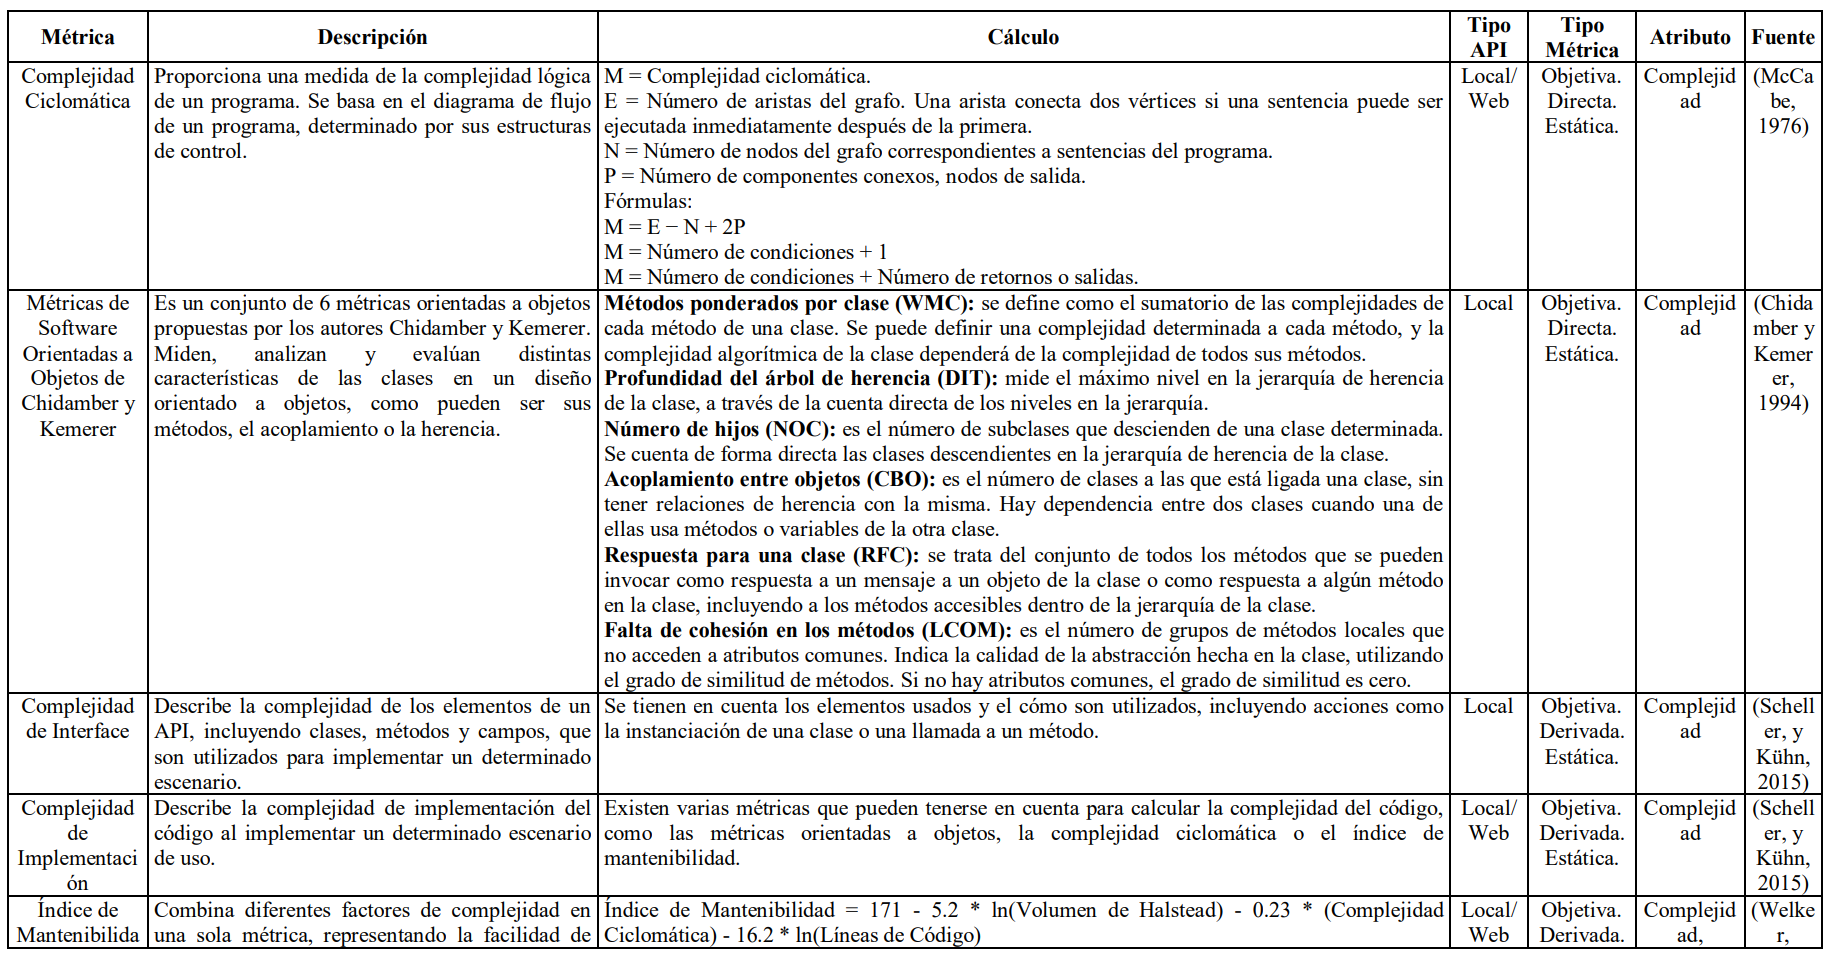
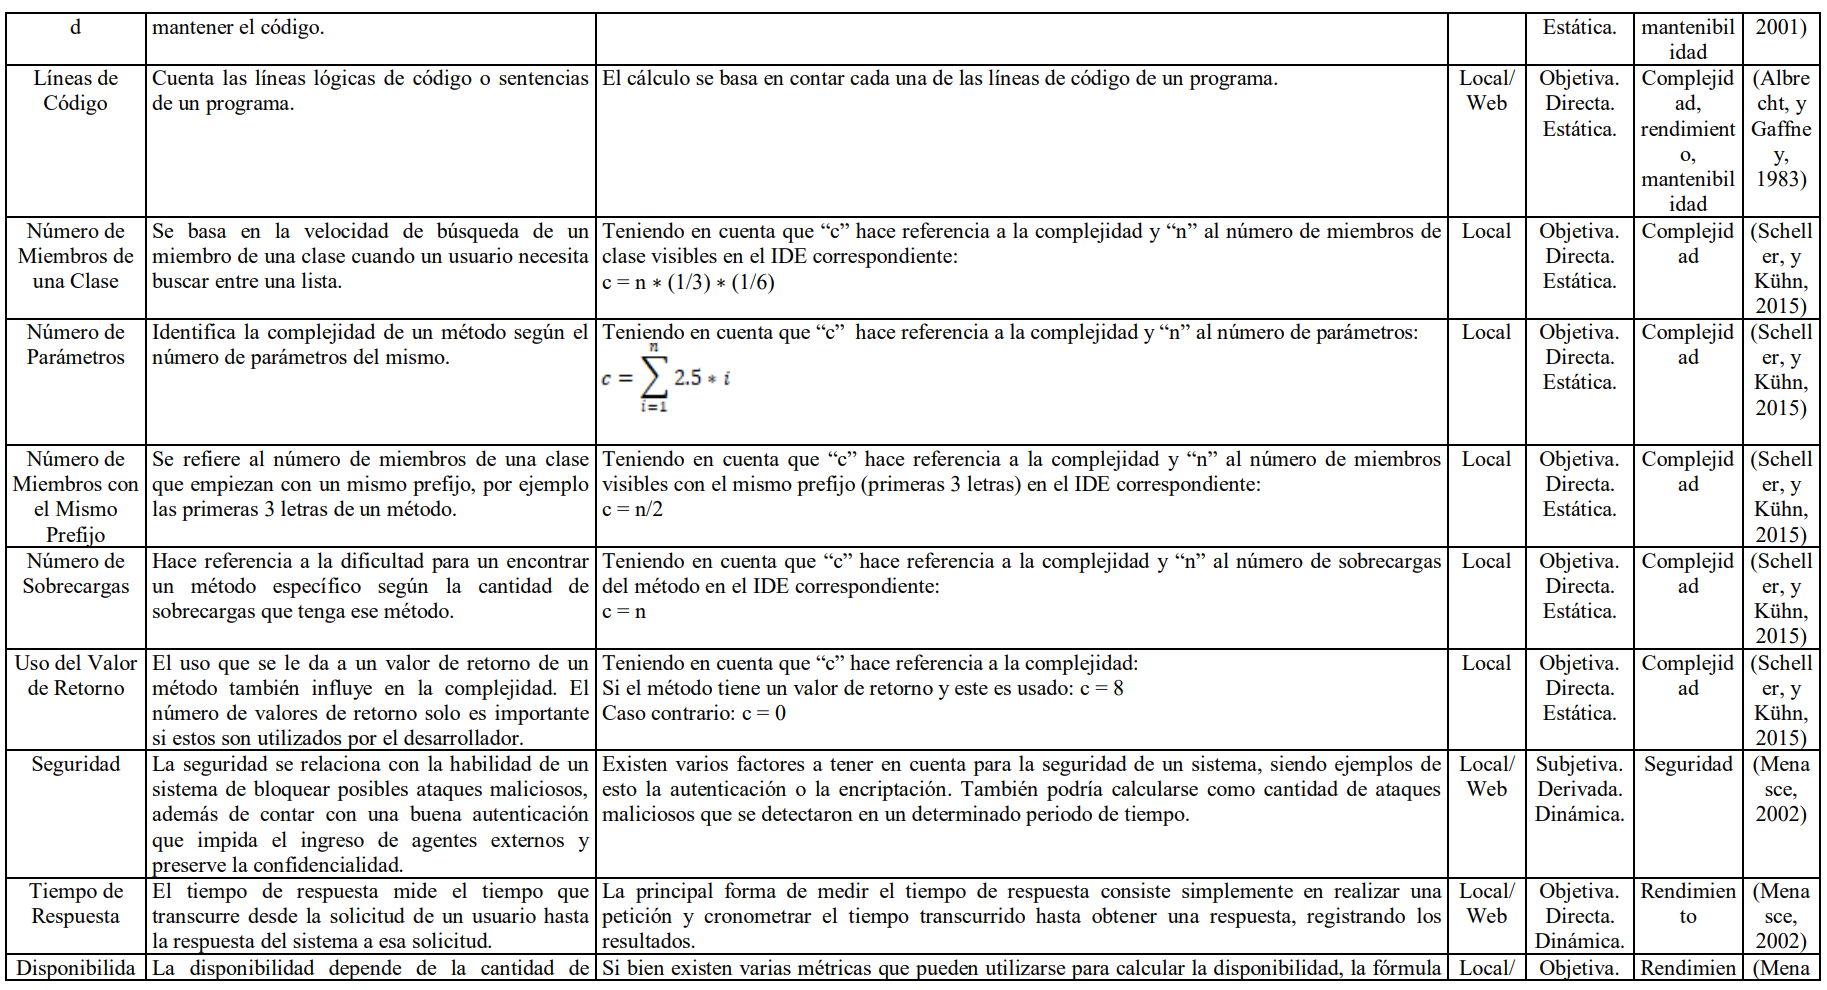
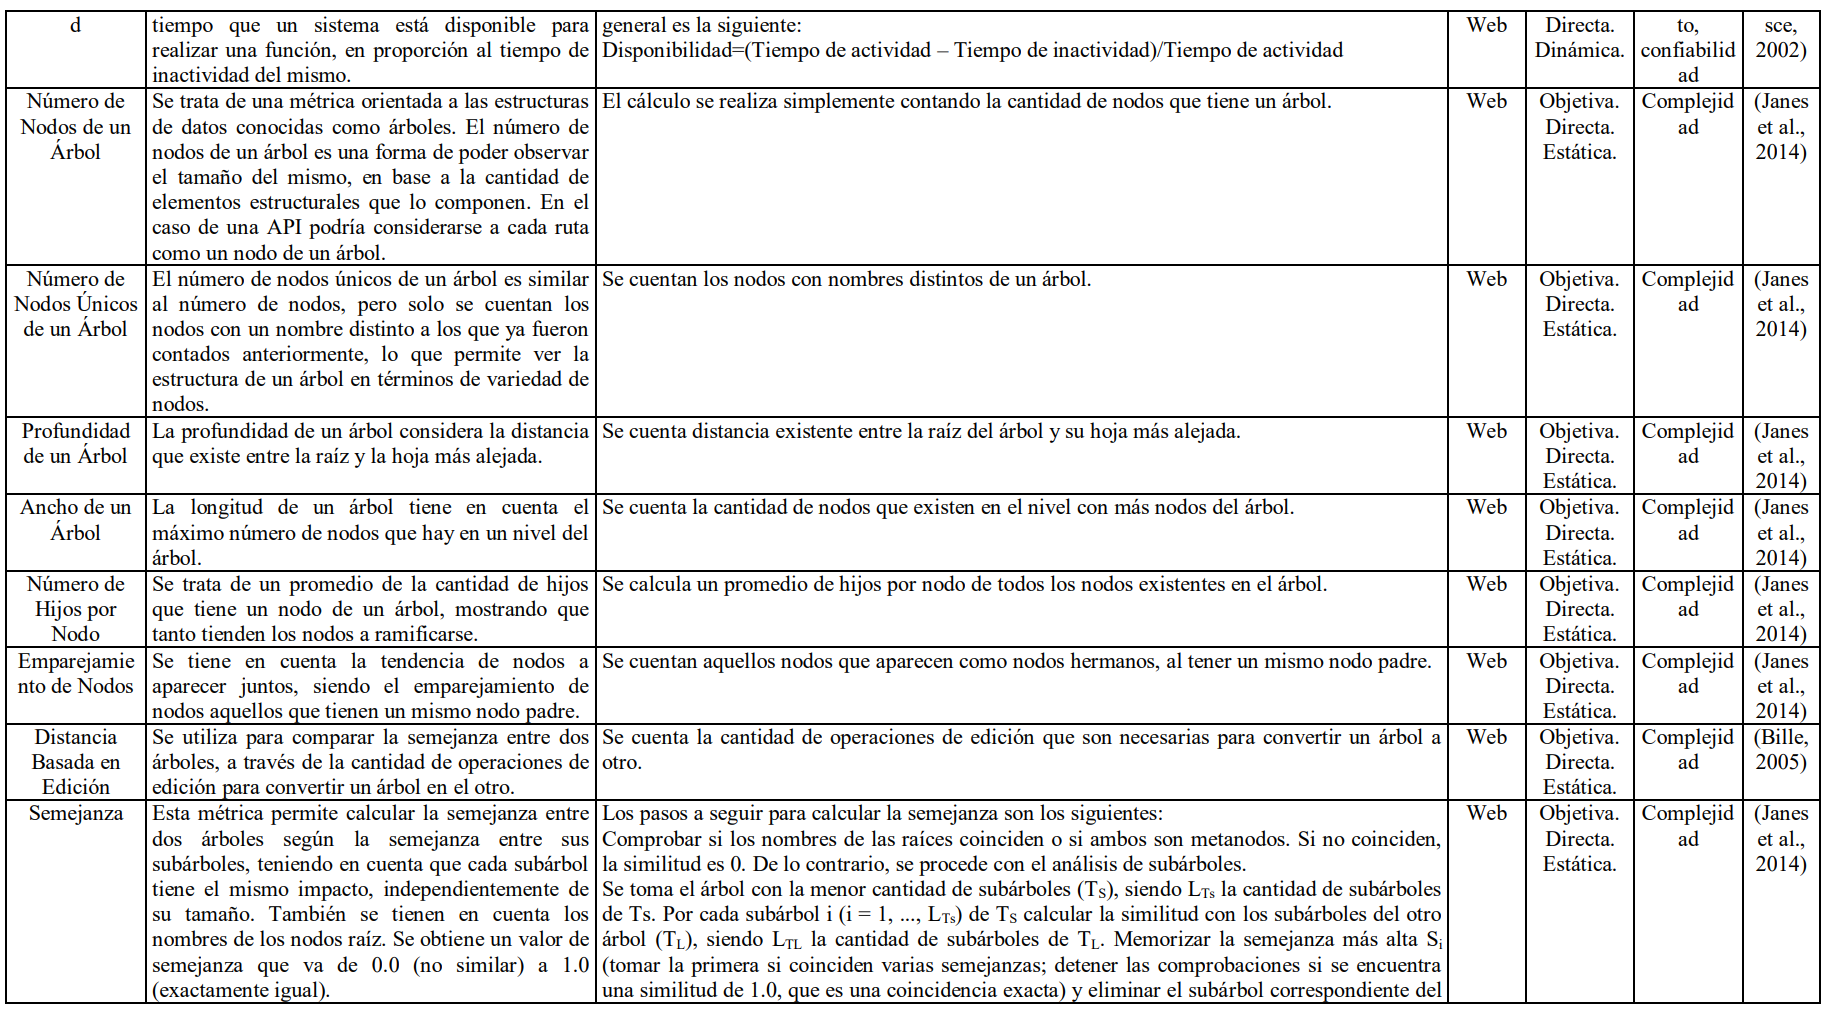
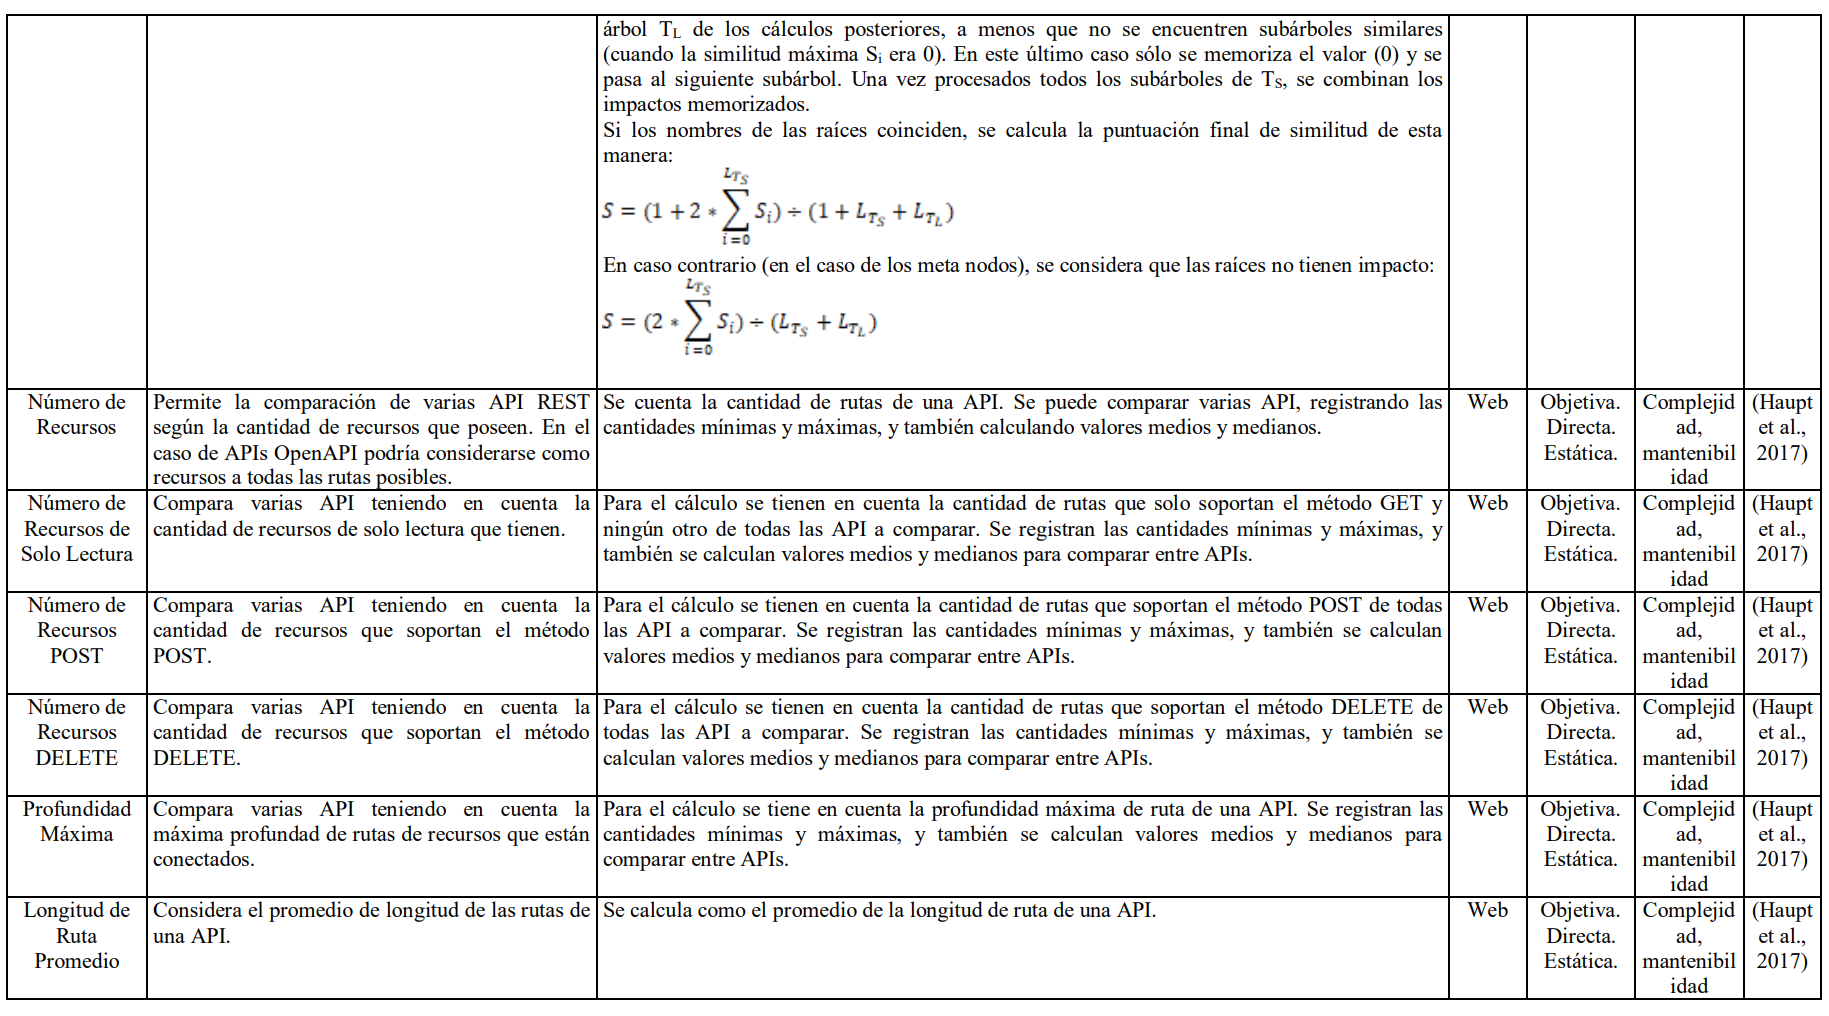
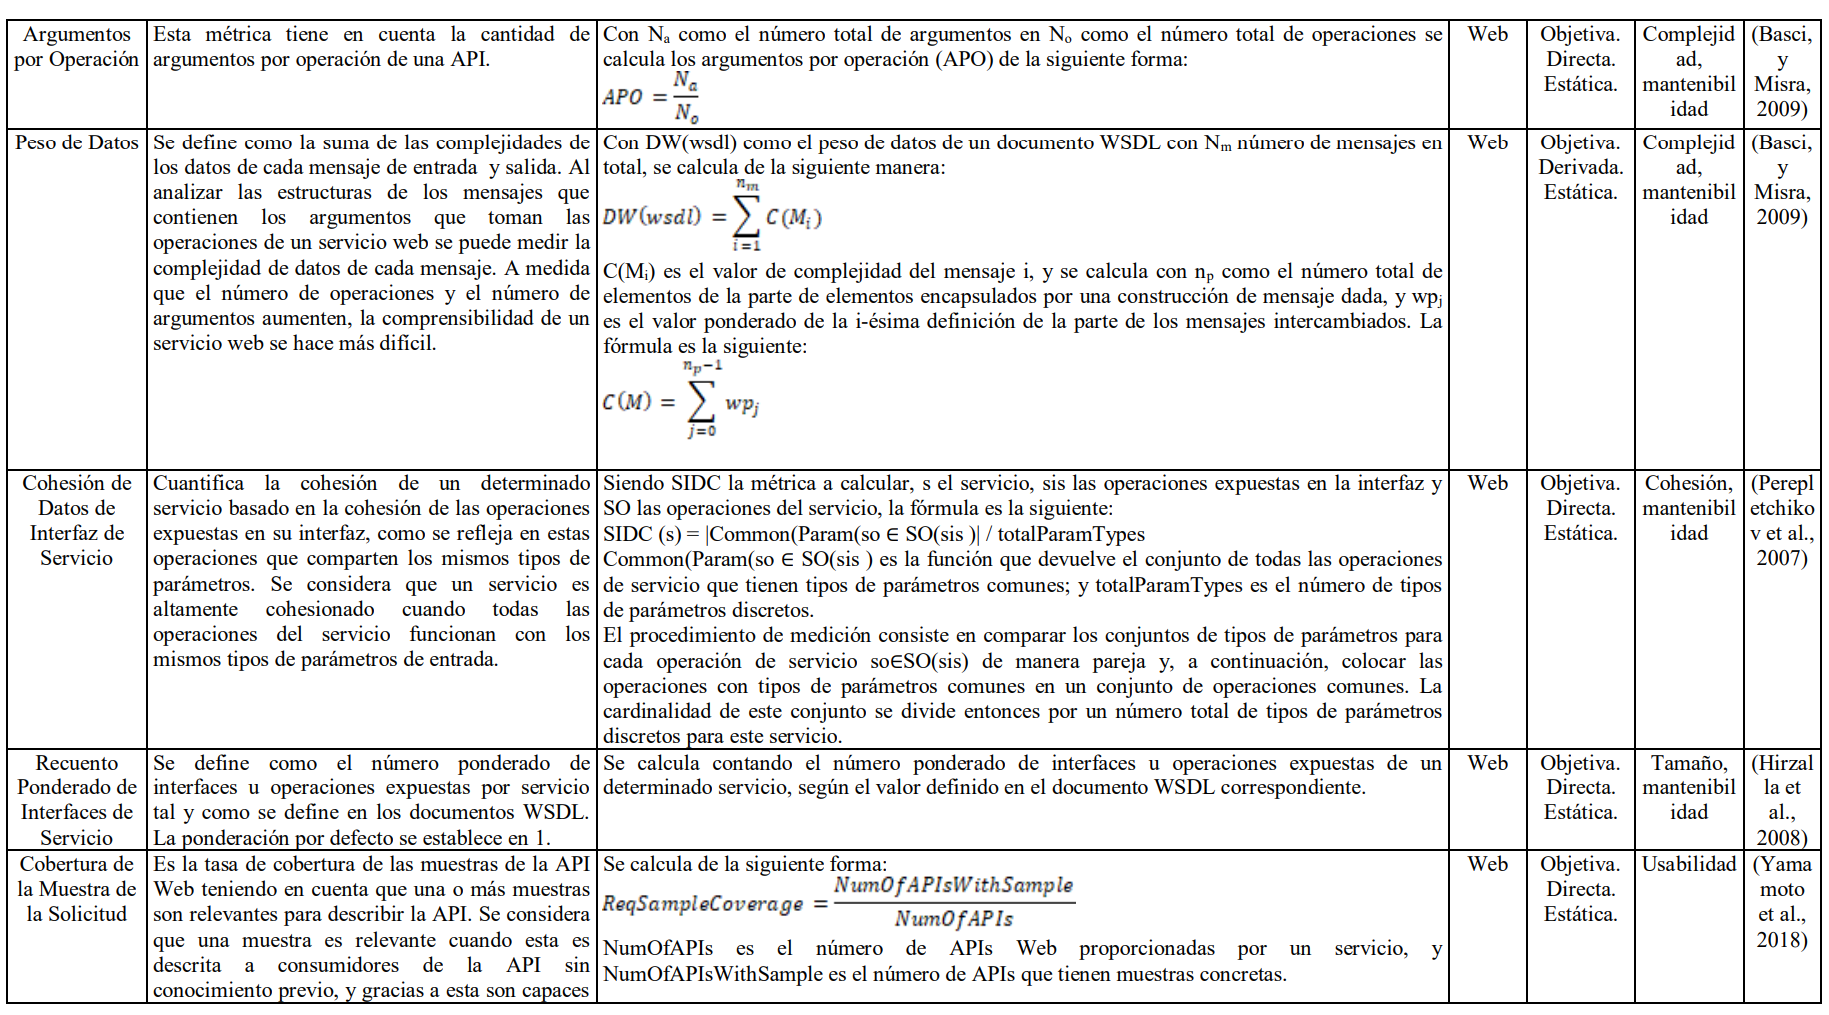
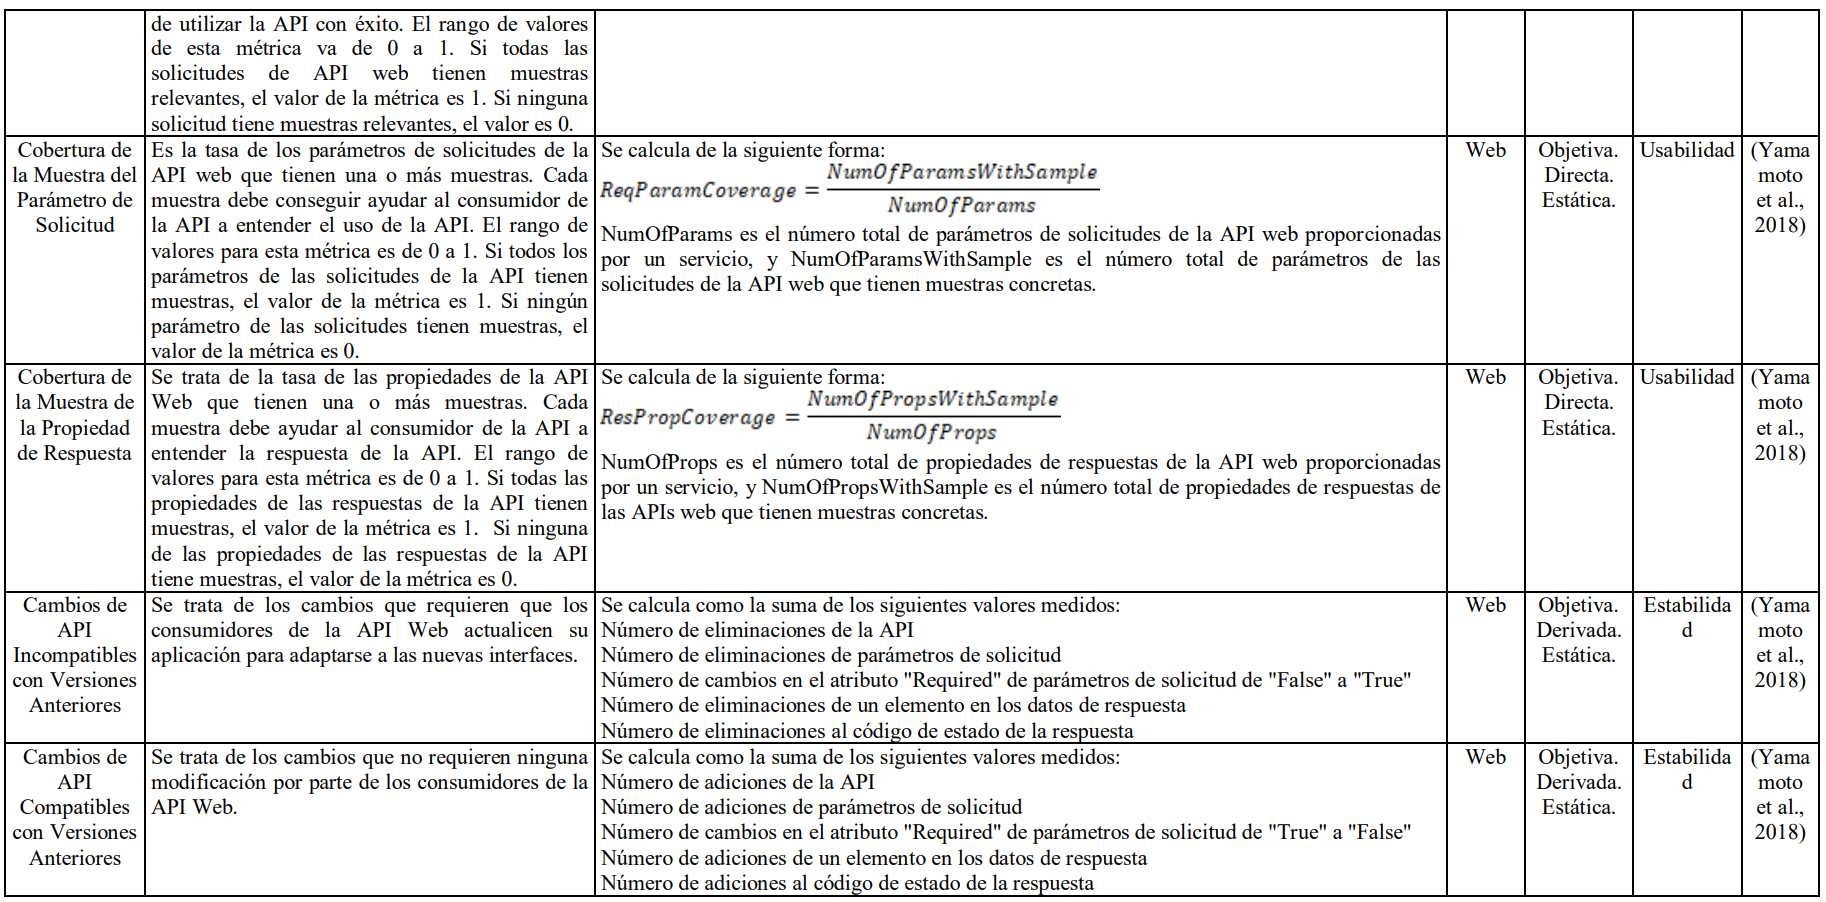

# Como hacer un vínculo entre ambas cosas, langchain y metricas en app usando llm

Al aprovechar la diversidad de proveedores LLM que ofrece "LangChain", los usuarios pueden aplicar una variedad de métricas de evaluación para medir la calidad y eficacia de las salidas generadas. Una de estas métricas es la **Similaridad de Coseno**, que mide la similitud semántica entre vectores de características. Al integrar esta métrica en la funcionalidad de "LangChain", los usuarios pueden evaluar la coherencia y la precisión de las respuestas generadas por los LLMs conectados en la cadena.

Además, en el contexto de traducción automática proporcionada por los proveedores LLM en "LangChain", las métricas como **BLEU** y **ROUGE** podrían aplicarse para evaluar la calidad de las traducciones generadas. Esto garantizaría que las cadenas de modelos de lenguaje largo en "LangChain" produzcan traducciones precisas y coherentes, proporcionando resultados más satisfactorios para los usuarios.

### Similaridad de Coseno

En el contexto de LangChain, esta métrica podría ser utilizada para evaluar la similitud semántica entre las respuestas generadas por los distintos modelos de lenguaje largo conectados en una cadena. Por ejemplo, si LangChain combina respuestas de diferentes proveedores LLM, la Similaridad de Coseno podría ayudar a identificar si las respuestas son coherentes entre sí. Si la similitud de coseno entre dos respuestas es alta, esto podría indicar que las respuestas son consistentes y concuerdan en su contenido.

### BLEU (Bilingual Evaluation Understudy) y ROUGE (Recall-Oriented Understudy for Gisting Evaluation):
Estas métricas son comúnmente utilizadas para evaluar la calidad de traducciones automáticas o resúmenes generados por modelos de lenguaje largo. En el contexto de LangChain, donde varios proveedores LLM se utilizan para la generación de texto, BLEU y ROUGE podrían ser aplicados para evaluar la calidad de las traducciones o resúmenes generados por la cadena de modelos. Esto ayudaría a identificar cuál de los proveedores LLM está produciendo resultados más precisos y coherentes en términos de traducción y resumen.

#### Ejemplo implementación Similaridad de Coseno

In [1]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Ejemplo de oraciones
sentence_1 = "La lluvia en Sevilla es una maravilla."
sentence_2 = "En Sevilla, la lluvia es un fenómeno poco común."

# Crear una matriz de frecuencia de términos (bag of words) para las oraciones
vectorizer = CountVectorizer().fit_transform([sentence_1, sentence_2])

# Obtener los vectores de las oraciones
vector_sentence_1 = vectorizer.toarray()[0]
vector_sentence_2 = vectorizer.toarray()[1]

# Calcular la similaridad de coseno entre los vectores de oraciones
similarity_score = cosine_similarity([vector_sentence_1], [vector_sentence_2])[0][0]
print(f"Similaridad de Coseno entre las oraciones: {similarity_score}")


Similaridad de Coseno entre las oraciones: 0.6299407883487119
